In [53]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os, json
from shapely.geometry import Polygon
import random
import os
import json
import copy
from tqdm import tqdm
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os, json
from shapely.geometry import Polygon
import random
import imutils
import numpy as np
from PIL import Image
from module.segmentation_package.src.visualize import display_instances
from module.segmentation_package.src.utils import get_dataset_dicts
from pycocotools import mask


def get_image_class(data, image_id):
    for i in data['images']:
        if i['id'] == image_id:
            return i


def read_json(data):
    with open(data) as f:
        return json.load(f)


def save_json(data, path):
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(data, f)


def get_mask(image, segm):
    polygon = []

    for i in range(int(len(segm) / 2)):
        polygon.append([int(segm[2 * i]), int(segm[2 * i + 1])])

    pts = np.array(polygon)
    ## (1) Crop the bounding rect
    rect = cv2.boundingRect(pts)
    croped = image.copy()

    ## (2) make mask
    pts = pts

    croped_binary_mask = np.zeros(croped.shape[:2], np.uint8)
    cv2.drawContours(croped_binary_mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

    ## (3) do bit-op
    dst = cv2.bitwise_and(croped, croped, mask=croped_binary_mask)
    return dst, croped_binary_mask, rect


def get_images(instance):
    file_name    = instance['file_name']
    segmentation = instance['segmentation']
    
    img_full = cv2.imread(file_name)
    img_full = cv2.cvtColor(img_full, cv2.COLOR_BGR2RGB)
    full_mask, binary_mask, rect = get_mask(img_full, segmentation)
    x, y, w, h = rect #[y:y + h, x:x + w] #[rect[1]:rect[1] + rect[3], rect[0]:rect[0] + rect[2]]
    return {
        'image_full': img_full,
        'full_mask': full_mask,
        'binary_mask': binary_mask,
        'rect': [max(0, x), max(0, y), w, h]
    }

def get_images_from_instance(data_instance, dst_size=(1440, 1440)):

    img_full = cv2.imread(data_instance['file_name'])
    img_full = cv2.cvtColor(img_full, cv2.COLOR_BGR2RGB)
    src_size = img_full.shape[:2]
    
    img_full = cv2.resize(img_full, dst_size)
    
    scale = (src_size[0]/dst_size[0], src_size[1]/dst_size[1])
    
    img_data = {
        'image_full': img_full,
        'full_mask': [],
        'binary_mask': [],
        'rect': []
    }
    
    for i in data_instance['annotations']:
        new_segm_points = []
        for poin_seg in range(int(len(i['segmentation'][0])/2)):
            new_segm_points.append(i['segmentation'][0][2 * poin_seg] / scale[1])
            new_segm_points.append(i['segmentation'][0][2 * poin_seg + 1] / scale[0])
        full_mask, binary_mask, rect = get_mask(img_full, new_segm_points)
        x, y, w, h = rect #[y:y + h, x:x + w] #[rect[1]:rect[1] + rect[3], rect[0]:rect[0] + rect[2]]
        img_data['full_mask'].append(full_mask)
        img_data['binary_mask'].append(binary_mask)
        img_data['rect'].append([max(0, x), max(0, y), w, h])
        
    return img_data

In [23]:
def overlap2(rect1,rect2):
    p1 = Polygon([(rect1[0],rect1[1]), (rect1[0] + rect1[2], rect1[1]),(rect1[0] + rect1[2],rect1[1] + rect1[3]),(rect1[0],rect1[1] + rect1[3])])
    p2 = Polygon([(rect2[0],rect2[1]), (rect2[0] + rect2[2], rect2[1]),(rect2[0] + rect2[2],rect2[1] + rect2[3]),(rect2[0],rect2[1] + rect2[3])])
    intersection = p1.intersection(p2)
    return intersection.area
        
def check_fit(rectangles, rectangle):
    for i in rectangles:
        if overlap2(i, rectangle) > 0.0:
            return True
    return False

def get_copy_paste_instance(dataset):
    data_valid_ann = []
    for i in dataset:
        for z in i['annotations']:
            x_points = []
            y_points = []
            for point_id in range(int(len(z['segmentation'][0])/2)):
                x_points.append(z['segmentation'][0][2 * point_id])
                y_points.append(z['segmentation'][0][2 * point_id + 1])
            width = max(x_points) - min(x_points)
            height = max(y_points) - min(y_points)
            if width > 240 and height > 240:
                data_valid_ann.append({
                    'file_name'   : i['file_name'],
                    'segmentation': z['segmentation'][0]
                })
    return data_valid_ann
                
def generate_free_area(rectangles, size, max_box = 4):
    list_x = [[i[0], i[0]+i[2]] for i in rectangles]  
    list_x.append([0, size[1]])
    list_x = np.array(list_x).reshape(-1)
    list_x.sort()
    list_y = [[i[1], i[1]+i[3]] for i in rectangles]
    list_y.append([0, size[0]])
    list_y = np.array(list_y).reshape(-1)
    list_y.sort()
    
    all_posible_rectangles = []
    all_points = [[i, z] for z in list_y for ii, i in enumerate(list_x)]
    for i in all_points:
        for k in all_points[1:]:
            if i[0] != k[0] and i[1] != k[1]:
                rect = [i[0], i[1], k[0] - i[0], k[1] - i[1]]
                if min(rect) < 0: continue  
                state = check_fit(rectangles, rect)
                if not state:
                    all_posible_rectangles.append([rect, rect[2] * rect[3]])

    all_posible_rectangles = sorted(all_posible_rectangles, key=lambda x: x[1], reverse=False)
    id_to_remove = []
    for first in range(len(all_posible_rectangles)-1, -1, -1):
        if first in id_to_remove:
            continue
        for second in range(first-1, -1, -1):
            if overlap2(all_posible_rectangles[first][0], all_posible_rectangles[second][0]) > 0:
                id_to_remove.append(second)

    id_to_remove = list(set(id_to_remove))
    id_to_remove.sort(reverse=True)
    for i in id_to_remove:
        del all_posible_rectangles[i]
    all_posible_rectangles = sorted(all_posible_rectangles, key=lambda x: x[1], reverse=True)
    return [i[0] for i in all_posible_rectangles]


def resize_image(img, scale):
    w,h = img.shape[:2]
    imS = cv2.resize(img, ( int(h * scale), int(w * scale)))
    return imS

def get_orient(size):
    return 'horizontal' if size[0] > size[1] else 'vertical'

def check_size(rect, area, max_ratio = 9, min_area_ratio = 0.05):
    area_val = (rect[2] * rect[3])/(area[0] * area[1])
    ratio = rect[2] / rect[3]
    if ratio > max_ratio or ratio < 1/max_ratio:
        return False
    if area_val < min_area_ratio:
        return False
    return True

def get_rotate_angle(paste_box, input_mask):
    paste_box_state = 0
    input_mask_state = 0
    if paste_box[2]>paste_box[3]:
        paste_box_state = 1
    if input_mask[2]>input_mask[3]:
        input_mask_state = 1
        
    if paste_box_state == input_mask_state:
        return 1
    return 0 #ROTATE_90_CLOCKWISE


def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # rotate our image by 45 degrees around the center of the image
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

In [24]:
def overlay_image_alpha(img, img_overlay, x, y, alpha_mask):
    """Overlay `img_overlay` onto `img` at (x, y) and blend using `alpha_mask`.

    `alpha_mask` must have same HxW as `img_overlay` and values in range [0, 1].
    """
    # Image ranges
    y1, y2 = max(0, y), min(img.shape[0], y + img_overlay.shape[0])
    x1, x2 = max(0, x), min(img.shape[1], x + img_overlay.shape[1])

    # Overlay ranges
    y1o, y2o = max(0, -y), min(img_overlay.shape[0], img.shape[0] - y)
    x1o, x2o = max(0, -x), min(img_overlay.shape[1], img.shape[1] - x)

    # Exit if nothing to do
    if y1 >= y2 or x1 >= x2 or y1o >= y2o or x1o >= x2o:
        return

    # Blend overlay within the determined ranges
    img_crop = img[y1:y2, x1:x2]
    img_overlay_crop = img_overlay[y1o:y2o, x1o:x2o]
    alpha = alpha_mask[y1o:y2o, x1o:x2o, np.newaxis]
    alpha_inv = 1.0 - alpha
    img_crop[:] = alpha * img_overlay_crop + alpha_inv * img_crop
    return img_crop



In [42]:
def apply_mask(src, src_mask_origin, color_mask, binary_mask, angle, box, min_ratio = 0.025):
    
    if angle != 1:
        color_mask = cv2.rotate(color_mask, cv2.cv2.ROTATE_90_CLOCKWISE)
        binary_mask = cv2.rotate(binary_mask, cv2.cv2.ROTATE_90_CLOCKWISE)
    
    mask_size = binary_mask.shape[:2]
    
    if min(mask_size) < 50:
        return False, src, src_mask_origin, None
    scaling = round(min(box[2]/mask_size[0], box[3]/mask_size[1]), 3)
    
    if scaling < 1:
        scaling = scaling * 0.95
        color_mask = resize_image(color_mask, scaling)
        binary_mask = resize_image(binary_mask, scaling)
    
    mask_size = binary_mask.shape[:2]
    
    box_width = box[2]
    box_height = box[3]
    
    area_full = src.shape[0] * src.shape[1]
    area_mask = binary_mask.shape[0] * binary_mask.shape[1]
    
    if area_mask/area_full < min_ratio:
        return False, src, src_mask_origin, None
    
    mask_height, mask_width = mask_size
        
    off_y = random.randint(0,box_height - mask_height)
    off_x = random.randint(0,box_width - mask_width)
        
    offset = np.array((box[0] + off_x, box[1] + off_y))
    
    binary_mask_croped = binary_mask / 255.0
    binary_mask_origin = src_mask_origin / 255.0

    overlay_image_alpha(src, color_mask, offset[0], offset[1],  binary_mask_croped)
    
    zeros_matrix = np.zeros(binary_mask_origin.shape[:2], np.uint8)
    
    zeros_matrix[offset[1]:offset[1]+binary_mask_croped.shape[0],offset[0]:offset[0]+binary_mask_croped.shape[1]] = binary_mask_croped
    paste_rect = [offset[0], offset[1], binary_mask_croped.shape[1], binary_mask_croped.shape[0]]
    
    return True, src, zeros_matrix, paste_rect

def apply_copy_paste_aug(target_instance, data_valid_paste):
    target = get_images_from_instance(target_instance)
    
    src = target['image_full'].copy()
    rectangles = []

    ix = 0
    img_data = {
        'image': src,
        'bboxes': [],
        'masks': []
    }
    
    for id_current in range(len(target['rect'])):
        rectangles.append(target['rect'][id_current])
        b_box = [target['rect'][id_current][0], target['rect'][id_current][1],target['rect'][id_current][2],target['rect'][id_current][3]]
        
        img_data['bboxes'].append(b_box + [0] + [ix])
        img_data['masks'].append(target['binary_mask'][id_current].copy())
        ix += 1
    if len(img_data['bboxes']) > 1: return img_data

    paste_aug = random.sample(data_valid_paste, random.randint(1,5))

    for paste_aug_id in paste_aug:
        try:
            aug_img = get_images(paste_aug_id)
            rect_aug = aug_img['rect']
            full_mask = aug_img['full_mask'][rect_aug[1]:rect_aug[1] + rect_aug[3], rect_aug[0]:rect_aug[0] + rect_aug[2]]
            size_src_img = target['image_full'][0].shape[:2]
            all_free_places = generate_free_area(rectangles, (size_src_img[1], size_src_img[0]))
            if len(all_free_places) == 0:
                print("Stop none of empty areas")
                break

            i = all_free_places[0]

            target_image_size = target['full_mask'][0].shape[:2]
            state = check_size(i, target_image_size)
            if not state:
                print("Fish size isn't valid")
                break

            angle = get_rotate_angle(i,rect_aug)

            src_mask_origin = target['binary_mask'][0].copy()
            color_mask = aug_img['full_mask'][rect_aug[1]:rect_aug[1] + rect_aug[3], rect_aug[0]:rect_aug[0] + rect_aug[2]].copy()
            binary_mask = aug_img['binary_mask'][rect_aug[1]:rect_aug[1] + rect_aug[3], rect_aug[0]:rect_aug[0] + rect_aug[2]].copy()
            statet, src, binary_mask_origin, paste_rect = apply_mask(src, src_mask_origin, color_mask, binary_mask, angle, i)
            if not statet: continue
            b_box = [paste_rect[0], paste_rect[1], paste_rect[2], paste_rect[3]]
            img_data['bboxes'].append(b_box + [0] + [ix])
            img_data['masks'].append(binary_mask_origin.copy())
            rectangles.append(paste_rect)
            ix += 1
        except:
            pass
            
    return img_data

In [43]:
dataset = get_dataset_dicts('data/cache', 'Test', json_file="data/export.json")
data_valid_ann = get_copy_paste_instance(dataset)

Left: 27531
Left: 27530
Left: 27529
Left: 27528
Left: 27527
Left: 27526
Left: 27525
Left: 27524
Left: 27523
Left: 27522
Left: 27521
Left: 27520
Left: 27519
Left: 27518
Left: 27517
Left: 27516
Left: 27515
Left: 27514
Left: 27513
Left: 27512
Left: 27511
Left: 27510
Left: 27509
Left: 27508
Left: 27507
Left: 27506
Left: 27505
Left: 27504
Left: 27503
Left: 27502
Left: 27501
Left: 27500
Left: 27499
Left: 27498
Left: 27497
Left: 27496
Left: 27495
Left: 27494
Left: 27493
Left: 27492
Left: 27491
Left: 27490
Left: 27489
Left: 27488
Left: 27487
Left: 27486
Left: 27485
Left: 27484
Left: 27483
Left: 27482
Left: 27481
Left: 27480
Left: 27479
Left: 27478
Left: 27477
Left: 27476
Left: 27475
Left: 27474
Left: 27473
Left: 27472
Left: 27471
Left: 27470
Left: 27469
Left: 27468
Left: 27467
Left: 27466
Left: 27465
Left: 27464
Left: 27463
Left: 27462
Left: 27461
Left: 27460
Left: 27459
Left: 27458
Left: 27457
Left: 27456
Left: 27455
Left: 27454
Left: 27453
Left: 27452
Left: 27451
Left: 27450
Left: 27449
Left

Left: 26798
Left: 26797
Left: 26796
Left: 26795
Left: 26794
Left: 26793
Left: 26792
Left: 26791
Left: 26790
Left: 26789
Left: 26788
Left: 26787
Left: 26786
Left: 26785
Left: 26784
Left: 26783
Left: 26782
Left: 26781
Left: 26780
Left: 26779
Left: 26778
Left: 26777
Left: 26776
Left: 26775
Left: 26774
Left: 26773
Left: 26772
Left: 26771
Left: 26770
Left: 26769
Left: 26768
Left: 26767
Left: 26766
Left: 26765
Left: 26764
Left: 26763
Left: 26762
Left: 26761
Left: 26760
Left: 26759
Left: 26758
Left: 26757
Left: 26756
Left: 26755
Left: 26754
Left: 26753
Left: 26752
Left: 26751
Left: 26750
Left: 26749
Left: 26748
Left: 26747
Left: 26746
Left: 26745
Left: 26744
Left: 26743
Left: 26742
Left: 26741
Left: 26740
Left: 26739
Left: 26738
Left: 26737
Left: 26736
Left: 26735
Left: 26734
Left: 26733
Left: 26732
Left: 26731
Left: 26730
Left: 26729
Left: 26728
Left: 26727
Left: 26726
Left: 26725
Left: 26724
Left: 26723
Left: 26722
Left: 26721
Left: 26720
Left: 26719
Left: 26718
Left: 26717
Left: 26716
Left

Left: 26103
Left: 26102
Left: 26101
Left: 26100
Left: 26099
Left: 26098
Left: 26097
Left: 26096
Left: 26095
Left: 26094
Left: 26093
Left: 26092
Left: 26091
Left: 26090
Left: 26089
Left: 26088
Left: 26087
Left: 26086
Left: 26085
Left: 26084
Left: 26083
Left: 26082
Left: 26081
Left: 26080
Left: 26079
Left: 26078
Left: 26077
Left: 26076
Left: 26075
Left: 26074
Left: 26073
Left: 26072
Left: 26071
Left: 26070
Left: 26069
Left: 26068
Left: 26067
Left: 26066
Left: 26065
Left: 26064
Left: 26063
Left: 26062
Left: 26061
Left: 26060
Left: 26059
Left: 26058
Left: 26057
Left: 26056
Left: 26055
Left: 26054
Left: 26053
Left: 26052
Left: 26051
Left: 26050
Left: 26049
Left: 26048
Left: 26047
Left: 26046
Left: 26045
Left: 26044
Left: 26043
Left: 26042
Left: 26041
Left: 26040
Left: 26039
Left: 26038
Left: 26037
Left: 26036
Left: 26035
Left: 26034
Left: 26033
Left: 26032
Left: 26031
Left: 26030
Left: 26029
Left: 26028
Left: 26027
Left: 26026
Left: 26025
Left: 26024
Left: 26023
Left: 26022
Left: 26021
Left

Left: 25395
Left: 25394
Left: 25393
Left: 25392
Left: 25391
Left: 25390
Left: 25389
Left: 25388
Left: 25387
Left: 25386
Left: 25385
Left: 25384
Left: 25383
Left: 25382
Left: 25381
Left: 25380
Left: 25379
Left: 25378
Left: 25377
Left: 25376
Left: 25375
Left: 25374
Left: 25373
Left: 25372
Left: 25371
Left: 25370
Left: 25369
Left: 25368
Left: 25367
Left: 25366
Left: 25365
Left: 25364
Left: 25363
Left: 25362
Left: 25361
Left: 25360
Left: 25359
Left: 25358
Left: 25357
Left: 25356
Left: 25355
Left: 25354
Left: 25353
Left: 25352
Left: 25351
Left: 25350
Left: 25349
Left: 25348
Left: 25347
Left: 25346
Left: 25345
Left: 25344
Left: 25343
Left: 25342
Left: 25341
Left: 25340
Left: 25339
Left: 25338
Left: 25337
Left: 25336
Left: 25335
Left: 25334
Left: 25333
Left: 25332
Left: 25331
Left: 25330
Left: 25329
Left: 25328
Left: 25327
Left: 25326
Left: 25325
Left: 25324
Left: 25323
Left: 25322
Left: 25321
Left: 25320
Left: 25319
Left: 25318
Left: 25317
Left: 25316
Left: 25315
Left: 25314
Left: 25313
Left

Left: 24704
Left: 24703
Left: 24702
Left: 24701
Left: 24700
Left: 24699
Left: 24698
Left: 24697
Left: 24696
Left: 24695
Left: 24694
Left: 24693
Left: 24692
Left: 24691
Left: 24690
Left: 24689
Left: 24688
Left: 24687
Left: 24686
Left: 24685
Left: 24684
Left: 24683
Left: 24682
Left: 24681
Left: 24680
Left: 24679
Left: 24678
Left: 24677
Left: 24676
Left: 24675
Left: 24674
Left: 24673
Left: 24672
Left: 24671
Left: 24670
Left: 24669
Left: 24668
Left: 24667
Left: 24666
Left: 24665
Left: 24664
Left: 24663
Left: 24662
Left: 24661
Left: 24660
Left: 24659
Left: 24658
Left: 24657
Left: 24656
Left: 24655
Left: 24654
Left: 24653
Left: 24652
Left: 24651
Left: 24650
Left: 24649
Left: 24648
Left: 24647
Left: 24646
Left: 24645
Left: 24644
Left: 24643
Left: 24642
Left: 24641
Left: 24640
Left: 24639
Left: 24638
Left: 24637
Left: 24636
Left: 24635
Left: 24634
Left: 24633
Left: 24632
Left: 24631
Left: 24630
Left: 24629
Left: 24628
Left: 24627
Left: 24626
Left: 24625
Left: 24624
Left: 24623
Left: 24622
Left

Left: 23998
Left: 23997
Left: 23996
Left: 23995
Left: 23994
Left: 23993
Left: 23992
Left: 23991
Left: 23990
Left: 23989
Left: 23988
Left: 23987
Left: 23986
Left: 23985
Left: 23984
Left: 23983
Left: 23982
Left: 23981
Left: 23980
Left: 23979
Left: 23978
Left: 23977
Left: 23976
Left: 23975
Left: 23974
Left: 23973
Left: 23972
Left: 23971
Left: 23970
Left: 23969
Left: 23968
Left: 23967
Left: 23966
Left: 23965
Left: 23964
Left: 23963
Left: 23962
Left: 23961
Left: 23960
Left: 23959
Left: 23958
Left: 23957
Left: 23956
Left: 23955
Left: 23954
Left: 23953
Left: 23952
Left: 23951
Left: 23950
Left: 23949
Left: 23948
Left: 23947
Left: 23946
Left: 23945
Left: 23944
Left: 23943
Left: 23942
Left: 23941
Left: 23940
Left: 23939
Left: 23938
Left: 23937
Left: 23936
Left: 23935
Left: 23934
Left: 23933
Left: 23932
Left: 23931
Left: 23930
Left: 23929
Left: 23928
Left: 23927
Left: 23926
Left: 23925
Left: 23924
Left: 23923
Left: 23922
Left: 23921
Left: 23920
Left: 23919
Left: 23918
Left: 23917
Left: 23916
Left

Left: 23291
Left: 23290
Left: 23289
Left: 23288
Left: 23287
Left: 23286
Left: 23285
Left: 23284
Left: 23283
Left: 23282
Left: 23281
Left: 23280
Left: 23279
Left: 23278
Left: 23277
Left: 23276
Left: 23275
Left: 23274
Left: 23273
Left: 23272
Left: 23271
Left: 23270
Left: 23269
Left: 23268
Left: 23267
Left: 23266
Left: 23265
Left: 23264
Left: 23263
Left: 23262
Left: 23261
Left: 23260
Left: 23259
Left: 23258
Left: 23257
Left: 23256
Left: 23255
Left: 23254
Left: 23253
Left: 23252
Left: 23251
Left: 23250
Left: 23249
Left: 23248
Left: 23247
Left: 23246
Left: 23245
Left: 23244
Left: 23243
Left: 23242
Left: 23241
Left: 23240
Left: 23239
Left: 23238
Left: 23237
Left: 23236
Left: 23235
Left: 23234
Left: 23233
Left: 23232
Left: 23231
Left: 23230
Left: 23229
Left: 23228
Left: 23227
Left: 23226
Left: 23225
Left: 23224
Left: 23223
Left: 23222
Left: 23221
Left: 23220
Left: 23219
Left: 23218
Left: 23217
Left: 23216
Left: 23215
Left: 23214
Left: 23213
Left: 23212
Left: 23211
Left: 23210
Left: 23209
Left

Left: 22589
Left: 22588
Left: 22587
Left: 22586
Left: 22585
Left: 22584
Left: 22583
Left: 22582
Left: 22581
Left: 22580
Left: 22579
Left: 22578
Left: 22577
Left: 22576
Left: 22575
Left: 22574
Left: 22573
Left: 22572
Left: 22571
Left: 22570
Left: 22569
Left: 22568
Left: 22567
Left: 22566
Left: 22565
Left: 22564
Left: 22563
Left: 22562
Left: 22561
Left: 22560
Left: 22559
Left: 22558
Left: 22557
Left: 22556
Left: 22555
Left: 22554
Left: 22553
Left: 22552
Left: 22551
Left: 22550
Left: 22549
Left: 22548
Left: 22547
Left: 22546
Left: 22545
Left: 22544
Left: 22543
Left: 22542
Left: 22541
Left: 22540
Left: 22539
Left: 22538
Left: 22537
Left: 22536
Left: 22535
Left: 22534
Left: 22533
Left: 22532
Left: 22531
Left: 22530
Left: 22529
Left: 22528
Left: 22527
Left: 22526
Left: 22525
Left: 22524
Left: 22523
Left: 22522
Left: 22521
Left: 22520
Left: 22519
Left: 22518
Left: 22517
Left: 22516
Left: 22515
Left: 22514
Left: 22513
Left: 22512
Left: 22511
Left: 22510
Left: 22509
Left: 22508
Left: 22507
Left

Left: 21873
Left: 21872
Left: 21871
Left: 21870
Left: 21869
Left: 21868
Left: 21867
Left: 21866
Left: 21865
Left: 21864
Left: 21863
Left: 21862
Left: 21861
Left: 21860
Left: 21859
Left: 21858
Left: 21857
Left: 21856
Left: 21855
Left: 21854
Left: 21853
Left: 21852
Left: 21851
Left: 21850
Left: 21849
Left: 21848
Left: 21847
Left: 21846
Left: 21845
Left: 21844
Left: 21843
Left: 21842
Left: 21841
Left: 21840
Left: 21839
Left: 21838
Left: 21837
Left: 21836
Left: 21835
Left: 21834
Left: 21833
Left: 21832
Left: 21831
Left: 21830
Left: 21829
Left: 21828
Left: 21827
Left: 21826
Left: 21825
Left: 21824
Left: 21823
Left: 21822
Left: 21821
Left: 21820
Left: 21819
Left: 21818
Left: 21817
Left: 21816
Left: 21815
Left: 21814
Left: 21813
Left: 21812
Left: 21811
Left: 21810
Left: 21809
Left: 21808
Left: 21807
Left: 21806
Left: 21805
Left: 21804
Left: 21803
Left: 21802
Left: 21801
Left: 21800
Left: 21799
Left: 21798
Left: 21797
Left: 21796
Left: 21795
Left: 21794
Left: 21793
Left: 21792
Left: 21791
Left

Left: 21157
Left: 21156
Left: 21155
Left: 21154
Left: 21153
Left: 21152
Left: 21151
Left: 21150
Left: 21149
Left: 21148
Left: 21147
Left: 21146
Left: 21145
Left: 21144
Left: 21143
Left: 21142
Left: 21141
Left: 21140
Left: 21139
Left: 21138
Left: 21137
Left: 21136
Left: 21135
Left: 21134
Left: 21133
Left: 21132
Left: 21131
Left: 21130
Left: 21129
Left: 21128
Left: 21127
Left: 21126
Left: 21125
Left: 21124
Left: 21123
Left: 21122
Left: 21121
Left: 21120
Left: 21119
Left: 21118
Left: 21117
Left: 21116
Left: 21115
Left: 21114
Left: 21113
Left: 21112
Left: 21111
Left: 21110
Left: 21109
Left: 21108
Left: 21107
Left: 21106
Left: 21105
Left: 21104
Left: 21103
Left: 21102
Left: 21101
Left: 21100
Left: 21099
Left: 21098
Left: 21097
Left: 21096
Left: 21095
Left: 21094
Left: 21093
Left: 21092
Left: 21091
Left: 21090
Left: 21089
Left: 21088
Left: 21087
Left: 21086
Left: 21085
Left: 21084
Left: 21083
Left: 21082
Left: 21081
Left: 21080
Left: 21079
Left: 21078
Left: 21077
Left: 21076
Left: 21075
Left

Left: 20474
Left: 20473
Left: 20472
Left: 20471
Left: 20470
Left: 20469
Left: 20468
Left: 20467
Left: 20466
Left: 20465
Left: 20464
Left: 20463
Left: 20462
Left: 20461
Left: 20460
Left: 20459
Left: 20458
Left: 20457
Left: 20456
Left: 20455
Left: 20454
Left: 20453
Left: 20452
Left: 20451
Left: 20450
Left: 20449
Left: 20448
Left: 20447
Left: 20446
Left: 20445
Left: 20444
Left: 20443
Left: 20442
Left: 20441
Left: 20440
Left: 20439
Left: 20438
Left: 20437
Left: 20436
Left: 20435
Left: 20434
Left: 20433
Left: 20432
Left: 20431
Left: 20430
Left: 20429
Left: 20428
Left: 20427
Left: 20426
Left: 20425
Left: 20424
Left: 20423
Left: 20422
Left: 20421
Left: 20420
Left: 20419
Left: 20418
Left: 20417
Left: 20416
Left: 20415
Left: 20414
Left: 20413
Left: 20412
Left: 20411
Left: 20410
Left: 20409
Left: 20408
Left: 20407
Left: 20406
Left: 20405
Left: 20404
Left: 20403
Left: 20402
Left: 20401
Left: 20400
Left: 20399
Left: 20398
Left: 20397
Left: 20396
Left: 20395
Left: 20394
Left: 20393
Left: 20392
Left

Left: 19782
Left: 19781
Left: 19780
Left: 19779
Left: 19778
Left: 19777
Left: 19776
Left: 19775
Left: 19774
Left: 19773
Left: 19772
Left: 19771
Left: 19770
Left: 19769
Left: 19768
Left: 19767
Left: 19766
Left: 19765
Left: 19764
Left: 19763
Left: 19762
Left: 19761
Left: 19760
Left: 19759
Left: 19758
Left: 19757
Left: 19756
Left: 19755
Left: 19754
Left: 19753
Left: 19752
Left: 19751
Left: 19750
Left: 19749
Left: 19748
Left: 19747
Left: 19746
Left: 19745
Left: 19744
Left: 19743
Left: 19742
Left: 19741
Left: 19740
Left: 19739
Left: 19738
Left: 19737
Left: 19736
Left: 19735
Left: 19734
Left: 19733
Left: 19732
Left: 19731
Left: 19730
Left: 19729
Left: 19728
Left: 19727
Left: 19726
Left: 19725
Left: 19724
Left: 19723
Left: 19722
Left: 19721
Left: 19720
Left: 19719
Left: 19718
Left: 19717
Left: 19716
Left: 19715
Left: 19714
Left: 19713
Left: 19712
Left: 19711
Left: 19710
Left: 19709
Left: 19708
Left: 19707
Left: 19706
Left: 19705
Left: 19704
Left: 19703
Left: 19702
Left: 19701
Left: 19700
Left

Left: 19095
Left: 19094
Left: 19093
Left: 19092
Left: 19091
Left: 19090
Left: 19089
Left: 19088
Left: 19087
Left: 19086
Left: 19085
Left: 19084
Left: 19083
Left: 19082
Left: 19081
Left: 19080
Left: 19079
Left: 19078
Left: 19077
Left: 19076
Left: 19075
Left: 19074
Left: 19073
Left: 19072
Left: 19071
Left: 19070
Left: 19069
Left: 19068
Left: 19067
Left: 19066
Left: 19065
Left: 19064
Left: 19063
Left: 19062
Left: 19061
Left: 19060
Left: 19059
Left: 19058
Left: 19057
Left: 19056
Left: 19055
Left: 19054
Left: 19053
Left: 19052
Left: 19051
Left: 19050
Left: 19049
Left: 19048
Left: 19047
Left: 19046
Left: 19045
Left: 19044
Left: 19043
Left: 19042
Left: 19041
Left: 19040
Left: 19039
Left: 19038
Left: 19037
Left: 19036
Left: 19035
Left: 19034
Left: 19033
Left: 19032
Left: 19031
Left: 19030
Left: 19029
Left: 19028
Left: 19027
Left: 19026
Left: 19025
Left: 19024
Left: 19023
Left: 19022
Left: 19021
Left: 19020
Left: 19019
Left: 19018
Left: 19017
Left: 19016
Left: 19015
Left: 19014
Left: 19013
Left

Left: 18373
Left: 18372
Left: 18371
Left: 18370
Left: 18369
Left: 18368
Left: 18367
Left: 18366
Left: 18365
Left: 18364
Left: 18363
Left: 18362
Left: 18361
Left: 18360
Left: 18359
Left: 18358
Left: 18357
Left: 18356
Left: 18355
Left: 18354
Left: 18353
Left: 18352
Left: 18351
Left: 18350
Left: 18349
Left: 18348
Left: 18347
Left: 18346
Left: 18345
Left: 18344
Left: 18343
Left: 18342
Left: 18341
Left: 18340
Left: 18339
Left: 18338
Left: 18337
Left: 18336
Left: 18335
Left: 18334
Left: 18333
Left: 18332
Left: 18331
Left: 18330
Left: 18329
Left: 18328
Left: 18327
Left: 18326
Left: 18325
Left: 18324
Left: 18323
Left: 18322
Left: 18321
Left: 18320
Left: 18319
Left: 18318
Left: 18317
Left: 18316
Left: 18315
Left: 18314
Left: 18313
Left: 18312
Left: 18311
Left: 18310
Left: 18309
Left: 18308
Left: 18307
Left: 18306
Left: 18305
Left: 18304
Left: 18303
Left: 18302
Left: 18301
Left: 18300
Left: 18299
Left: 18298
Left: 18297
Left: 18296
Left: 18295
Left: 18294
Left: 18293
Left: 18292
Left: 18291
Left

Left: 17666
Left: 17665
Left: 17664
Left: 17663
Left: 17662
Left: 17661
Left: 17660
Left: 17659
Left: 17658
Left: 17657
Left: 17656
Left: 17655
Left: 17654
Left: 17653
Left: 17652
Left: 17651
Left: 17650
Left: 17649
Left: 17648
Left: 17647
Left: 17646
Left: 17645
Left: 17644
Left: 17643
Left: 17642
Left: 17641
Left: 17640
Left: 17639
Left: 17638
Left: 17637
Left: 17636
Left: 17635
Left: 17634
Left: 17633
Left: 17632
Left: 17631
Left: 17630
Left: 17629
Left: 17628
Left: 17627
Left: 17626
Left: 17625
Left: 17624
Left: 17623
Left: 17622
Left: 17621
Left: 17620
Left: 17619
Left: 17618
Left: 17617
Left: 17616
Left: 17615
Left: 17614
Left: 17613
Left: 17612
Left: 17611
Left: 17610
Left: 17609
Left: 17608
Left: 17607
Left: 17606
Left: 17605
Left: 17604
Left: 17603
Left: 17602
Left: 17601
Left: 17600
Left: 17599
Left: 17598
Left: 17597
Left: 17596
Left: 17595
Left: 17594
Left: 17593
Left: 17592
Left: 17591
Left: 17590
Left: 17589
Left: 17588
Left: 17587
Left: 17586
Left: 17585
Left: 17584
Left

Left: 16975
Left: 16974
Left: 16973
Left: 16972
Left: 16971
Left: 16970
Left: 16969
Left: 16968
Left: 16967
Left: 16966
Left: 16965
Left: 16964
Left: 16963
Left: 16962
Left: 16961
Left: 16960
Left: 16959
Left: 16958
Left: 16957
Left: 16956
Left: 16955
Left: 16954
Left: 16953
Left: 16952
Left: 16951
Left: 16950
Left: 16949
Left: 16948
Left: 16947
Left: 16946
Left: 16945
Left: 16944
Left: 16943
Left: 16942
Left: 16941
Left: 16940
Left: 16939
Left: 16938
Left: 16937
Left: 16936
Left: 16935
Left: 16934
Left: 16933
Left: 16932
Left: 16931
Left: 16930
Left: 16929
Left: 16928
Left: 16927
Left: 16926
Left: 16925
Left: 16924
Left: 16923
Left: 16922
Left: 16921
Left: 16920
Left: 16919
Left: 16918
Left: 16917
Left: 16916
Left: 16915
Left: 16914
Left: 16913
Left: 16912
Left: 16911
Left: 16910
Left: 16909
Left: 16908
Left: 16907
Left: 16906
Left: 16905
Left: 16904
Left: 16903
Left: 16902
Left: 16901
Left: 16900
Left: 16899
Left: 16898
Left: 16897
Left: 16896
Left: 16895
Left: 16894
Left: 16893
Left

Left: 16275
Left: 16274
Left: 16273
Left: 16272
Left: 16271
Left: 16270
Left: 16269
Left: 16268
Left: 16267
Left: 16266
Left: 16265
Left: 16264
Left: 16263
Left: 16262
Left: 16261
Left: 16260
Left: 16259
Left: 16258
Left: 16257
Left: 16256
Left: 16255
Left: 16254
Left: 16253
Left: 16252
Left: 16251
Left: 16250
Left: 16249
Left: 16248
Left: 16247
Left: 16246
Left: 16245
Left: 16244
Left: 16243
Left: 16242
Left: 16241
Left: 16240
Left: 16239
Left: 16238
Left: 16237
Left: 16236
Left: 16235
Left: 16234
Left: 16233
Left: 16232
Left: 16231
Left: 16230
Left: 16229
Left: 16228
Left: 16227
Left: 16226
Left: 16225
Left: 16224
Left: 16223
Left: 16222
Left: 16221
Left: 16220
Left: 16219
Left: 16218
Left: 16217
Left: 16216
Left: 16215
Left: 16214
Left: 16213
Left: 16212
Left: 16211
Left: 16210
Left: 16209
Left: 16208
Left: 16207
Left: 16206
Left: 16205
Left: 16204
Left: 16203
Left: 16202
Left: 16201
Left: 16200
Left: 16199
Left: 16198
Left: 16197
Left: 16196
Left: 16195
Left: 16194
Left: 16193
Left

Left: 15514
Left: 15513
Left: 15512
Left: 15511
Left: 15510
Left: 15509
Left: 15508
Left: 15507
Left: 15506
Left: 15505
Left: 15504
Left: 15503
Left: 15502
Left: 15501
Left: 15500
Left: 15499
Left: 15498
Left: 15497
Left: 15496
Left: 15495
Left: 15494
Left: 15493
Left: 15492
Left: 15491
Left: 15490
Left: 15489
Left: 15488
Left: 15487
Left: 15486
Left: 15485
Left: 15484
Left: 15483
Left: 15482
Left: 15481
Left: 15480
Left: 15479
Left: 15478
Left: 15477
Left: 15476
Left: 15475
Left: 15474
Left: 15473
Left: 15472
Left: 15471
Left: 15470
Left: 15469
Left: 15468
Left: 15467
Left: 15466
Left: 15465
Left: 15464
Left: 15463
Left: 15462
Left: 15461
Left: 15460
Left: 15459
Left: 15458
Left: 15457
Left: 15456
Left: 15455
Left: 15454
Left: 15453
Left: 15452
Left: 15451
Left: 15450
Left: 15449
Left: 15448
Left: 15447
Left: 15446
Left: 15445
Left: 15444
Left: 15443
Left: 15442
Left: 15441
Left: 15440
Left: 15439
Left: 15438
Left: 15437
Left: 15436
Left: 15435
Left: 15434
Left: 15433
Left: 15432
Left

Left: 14805
Left: 14804
Left: 14803
Left: 14802
Left: 14801
Left: 14800
Left: 14799
Left: 14798
Left: 14797
Left: 14796
Left: 14795
Left: 14794
Left: 14793
Left: 14792
Left: 14791
Left: 14790
Left: 14789
Left: 14788
Left: 14787
Left: 14786
Left: 14785
Left: 14784
Left: 14783
Left: 14782
Left: 14781
Left: 14780
Left: 14779
Left: 14778
Left: 14777
Left: 14776
Left: 14775
Left: 14774
Left: 14773
Left: 14772
Left: 14771
Left: 14770
Left: 14769
Left: 14768
Left: 14767
Left: 14766
Left: 14765
Left: 14764
Left: 14763
Left: 14762
Left: 14761
Left: 14760
Left: 14759
Left: 14758
Left: 14757
Left: 14756
Left: 14755
Left: 14754
Left: 14753
Left: 14752
Left: 14751
Left: 14750
Left: 14749
Left: 14748
Left: 14747
Left: 14746
Left: 14745
Left: 14744
Left: 14743
Left: 14742
Left: 14741
Left: 14740
Left: 14739
Left: 14738
Left: 14737
Left: 14736
Left: 14735
Left: 14734
Left: 14733
Left: 14732
Left: 14731
Left: 14730
Left: 14729
Left: 14728
Left: 14727
Left: 14726
Left: 14725
Left: 14724
Left: 14723
Left

Left: 14054
Left: 14053
Left: 14052
Left: 14051
Left: 14050
Left: 14049
Left: 14048
Left: 14047
Left: 14046
Left: 14045
Left: 14044
Left: 14043
Left: 14042
Left: 14041
Left: 14040
Left: 14039
Left: 14038
Left: 14037
Left: 14036
Left: 14035
Left: 14034
Left: 14033
Left: 14032
Left: 14031
Left: 14030
Left: 14029
Left: 14028
Left: 14027
Left: 14026
Left: 14025
Left: 14024
Left: 14023
Left: 14022
Left: 14021
Left: 14020
Left: 14019
Left: 14018
Left: 14017
Left: 14016
Left: 14015
Left: 14014
Left: 14013
Left: 14012
Left: 14011
Left: 14010
Left: 14009
Left: 14008
Left: 14007
Left: 14006
Left: 14005
Left: 14004
Left: 14003
Left: 14002
Left: 14001
Left: 14000
Left: 13999
Left: 13998
Left: 13997
Left: 13996
Left: 13995
Left: 13994
Left: 13993
Left: 13992
Left: 13991
Left: 13990
Left: 13989
Left: 13988
Left: 13987
Left: 13986
Left: 13985
Left: 13984
Left: 13983
Left: 13982
Left: 13981
Left: 13980
Left: 13979
Left: 13978
Left: 13977
Left: 13976
Left: 13975
Left: 13974
Left: 13973
Left: 13972
Left

Left: 13331
Left: 13330
Left: 13329
Left: 13328
Left: 13327
Left: 13326
Left: 13325
Left: 13324
Left: 13323
Left: 13322
Left: 13321
Left: 13320
Left: 13319
Left: 13318
Left: 13317
Left: 13316
Left: 13315
Left: 13314
Left: 13313
Left: 13312
Left: 13311
Left: 13310
Left: 13309
Left: 13308
Left: 13307
Left: 13306
Left: 13305
Left: 13304
Left: 13303
Left: 13302
Left: 13301
Left: 13300
Left: 13299
Left: 13298
Left: 13297
Left: 13296
Left: 13295
Left: 13294
Left: 13293
Left: 13292
Left: 13291
Left: 13290
Left: 13289
Left: 13288
Left: 13287
Left: 13286
Left: 13285
Left: 13284
Left: 13283
Left: 13282
Left: 13281
Left: 13280
Left: 13279
Left: 13278
Left: 13277
Left: 13276
Left: 13275
Left: 13274
Left: 13273
Left: 13272
Left: 13271
Left: 13270
Left: 13269
Left: 13268
Left: 13267
Left: 13266
Left: 13265
Left: 13264
Left: 13263
Left: 13262
Left: 13261
Left: 13260
Left: 13259
Left: 13258
Left: 13257
Left: 13256
Left: 13255
Left: 13254
Left: 13253
Left: 13252
Left: 13251
Left: 13250
Left: 13249
Left

Left: 12622
Left: 12621
Left: 12620
Left: 12619
Left: 12618
Left: 12617
Left: 12616
Left: 12615
Left: 12614
Left: 12613
Left: 12612
Left: 12611
Left: 12610
Left: 12609
Left: 12608
Left: 12607
Left: 12606
Left: 12605
Left: 12604
Left: 12603
Left: 12602
Left: 12601
Left: 12600
Left: 12599
Left: 12598
Left: 12597
Left: 12596
Left: 12595
Left: 12594
Left: 12593
Left: 12592
Left: 12591
Left: 12590
Left: 12589
Left: 12588
Left: 12587
Left: 12586
Left: 12585
Left: 12584
Left: 12583
Left: 12582
Left: 12581
Left: 12580
Left: 12579
Left: 12578
Left: 12577
Left: 12576
Left: 12575
Left: 12574
Left: 12573
Left: 12572
Left: 12571
Left: 12570
Left: 12569
Left: 12568
Left: 12567
Left: 12566
Left: 12565
Left: 12564
Left: 12563
Left: 12562
Left: 12561
Left: 12560
Left: 12559
Left: 12558
Left: 12557
Left: 12556
Left: 12555
Left: 12554
Left: 12553
Left: 12552
Left: 12551
Left: 12550
Left: 12549
Left: 12548
Left: 12547
Left: 12546
Left: 12545
Left: 12544
Left: 12543
Left: 12542
Left: 12541
Left: 12540
Left

Left: 11920
Left: 11919
Left: 11918
Left: 11917
Left: 11916
Left: 11915
Left: 11914
Left: 11913
Left: 11912
Left: 11911
Left: 11910
Left: 11909
Left: 11908
Left: 11907
Left: 11906
Left: 11905
Left: 11904
Left: 11903
Left: 11902
Left: 11901
Left: 11900
Left: 11899
Left: 11898
Left: 11897
Left: 11896
Left: 11895
Left: 11894
Left: 11893
Left: 11892
Left: 11891
Left: 11890
Left: 11889
Left: 11888
Left: 11887
Left: 11886
Left: 11885
Left: 11884
Left: 11883
Left: 11882
Left: 11881
Left: 11880
Left: 11879
Left: 11878
Left: 11877
Left: 11876
Left: 11875
Left: 11874
Left: 11873
Left: 11872
Left: 11871
Left: 11870
Left: 11869
Left: 11868
Left: 11867
Left: 11866
Left: 11865
Left: 11864
Left: 11863
Left: 11862
Left: 11861
Left: 11860
Left: 11859
Left: 11858
Left: 11857
Left: 11856
Left: 11855
Left: 11854
Left: 11853
Left: 11852
Left: 11851
Left: 11850
Left: 11849
Left: 11848
Left: 11847
Left: 11846
Left: 11845
Left: 11844
Left: 11843
Left: 11842
Left: 11841
Left: 11840
Left: 11839
Left: 11838
Left

Left: 11231
Left: 11230
Left: 11229
Left: 11228
Left: 11227
Left: 11226
Left: 11225
Left: 11224
Left: 11223
Left: 11222
Left: 11221
Left: 11220
Left: 11219
Left: 11218
Left: 11217
Left: 11216
Left: 11215
Left: 11214
Left: 11213
Left: 11212
Left: 11211
Left: 11210
Left: 11209
Left: 11208
Left: 11207
Left: 11206
Left: 11205
Left: 11204
Left: 11203
Left: 11202
Left: 11201
Left: 11200
Left: 11199
Left: 11198
Left: 11197
Left: 11196
Left: 11195
Left: 11194
Left: 11193
Left: 11192
Left: 11191
Left: 11190
Left: 11189
Left: 11188
Left: 11187
Left: 11186
Left: 11185
Left: 11184
Left: 11183
Left: 11182
Left: 11181
Left: 11180
Left: 11179
Left: 11178
Left: 11177
Left: 11176
Left: 11175
Left: 11174
Left: 11173
Left: 11172
Left: 11171
Left: 11170
Left: 11169
Left: 11168
Left: 11167
Left: 11166
Left: 11165
Left: 11164
Left: 11163
Left: 11162
Left: 11161
Left: 11160
Left: 11159
Left: 11158
Left: 11157
Left: 11156
Left: 11155
Left: 11154
Left: 11153
Left: 11152
Left: 11151
Left: 11150
Left: 11149
Left

Left: 10539
Left: 10538
Left: 10537
Left: 10536
Left: 10535
Left: 10534
Left: 10533
Left: 10532
Left: 10531
Left: 10530
Left: 10529
Left: 10528
Left: 10527
Left: 10526
Left: 10525
Left: 10524
Left: 10523
Left: 10522
Left: 10521
Left: 10520
Left: 10519
Left: 10518
Left: 10517
Left: 10516
Left: 10515
Left: 10514
Left: 10513
Left: 10512
Left: 10511
Left: 10510
Left: 10509
Left: 10508
Left: 10507
Left: 10506
Left: 10505
Left: 10504
Left: 10503
Left: 10502
Left: 10501
Left: 10500
Left: 10499
Left: 10498
Left: 10497
Left: 10496
Left: 10495
Left: 10494
Left: 10493
Left: 10492
Left: 10491
Left: 10490
Left: 10489
Left: 10488
Left: 10487
Left: 10486
Left: 10485
Left: 10484
Left: 10483
Left: 10482
Left: 10481
Left: 10480
Left: 10479
Left: 10478
Left: 10477
Left: 10476
Left: 10475
Left: 10474
Left: 10473
Left: 10472
Left: 10471
Left: 10470
Left: 10469
Left: 10468
Left: 10467
Left: 10466
Left: 10465
Left: 10464
Left: 10463
Left: 10462
Left: 10461
Left: 10460
Left: 10459
Left: 10458
Left: 10457
Left

Left: 9830
Left: 9829
Left: 9828
Left: 9827
Left: 9826
Left: 9825
Left: 9824
Left: 9823
Left: 9822
Left: 9821
Left: 9820
Left: 9819
Left: 9818
Left: 9817
Left: 9816
Left: 9815
Left: 9814
Left: 9813
Left: 9812
Left: 9811
Left: 9810
Left: 9809
Left: 9808
Left: 9807
Left: 9806
Left: 9805
Left: 9804
Left: 9803
Left: 9802
Left: 9801
Left: 9800
Left: 9799
Left: 9798
Left: 9797
Left: 9796
Left: 9795
Left: 9794
Left: 9793
Left: 9792
Left: 9791
Left: 9790
Left: 9789
Left: 9788
Left: 9787
Left: 9786
Left: 9785
Left: 9784
Left: 9783
Left: 9782
Left: 9781
Left: 9780
Left: 9779
Left: 9778
Left: 9777
Left: 9776
Left: 9775
Left: 9774
Left: 9773
Left: 9772
Left: 9771
Left: 9770
Left: 9769
Left: 9768
Left: 9767
Left: 9766
Left: 9765
Left: 9764
Left: 9763
Left: 9762
Left: 9761
Left: 9760
Left: 9759
Left: 9758
Left: 9757
Left: 9756
Left: 9755
Left: 9754
Left: 9753
Left: 9752
Left: 9751
Left: 9750
Left: 9749
Left: 9748
Left: 9747
Left: 9746
Left: 9745
Left: 9744
Left: 9743
Left: 9742
Left: 9741
Left: 9740

Left: 9073
Left: 9072
Left: 9071
Left: 9070
Left: 9069
Left: 9068
Left: 9067
Left: 9066
Left: 9065
Left: 9064
Left: 9063
Left: 9062
Left: 9061
Left: 9060
Left: 9059
Left: 9058
Left: 9057
Left: 9056
Left: 9055
Left: 9054
Left: 9053
Left: 9052
Left: 9051
Left: 9050
Left: 9049
Left: 9048
Left: 9047
Left: 9046
Left: 9045
Left: 9044
Left: 9043
Left: 9042
Left: 9041
Left: 9040
Left: 9039
Left: 9038
Left: 9037
Left: 9036
Left: 9035
Left: 9034
Left: 9033
Left: 9032
Left: 9031
Left: 9030
Left: 9029
Left: 9028
Left: 9027
Left: 9026
Left: 9025
Left: 9024
Left: 9023
Left: 9022
Left: 9021
Left: 9020
Left: 9019
Left: 9018
Left: 9017
Left: 9016
Left: 9015
Left: 9014
Left: 9013
Left: 9012
Left: 9011
Left: 9010
Left: 9009
Left: 9008
Left: 9007
Left: 9006
Left: 9005
Left: 9004
Left: 9003
Left: 9002
Left: 9001
Left: 9000
Left: 8999
Left: 8998
Left: 8997
Left: 8996
Left: 8995
Left: 8994
Left: 8993
Left: 8992
Left: 8991
Left: 8990
Left: 8989
Left: 8988
Left: 8987
Left: 8986
Left: 8985
Left: 8984
Left: 8983

Left: 8264
Left: 8263
Left: 8262
Left: 8261
Left: 8260
Left: 8259
Left: 8258
Left: 8257
Left: 8256
Left: 8255
Left: 8254
Left: 8253
Left: 8252
Left: 8251
Left: 8250
Left: 8249
Left: 8248
Left: 8247
Left: 8246
Left: 8245
Left: 8244
Left: 8243
Left: 8242
Left: 8241
Left: 8240
Left: 8239
Left: 8238
Left: 8237
Left: 8236
Left: 8235
Left: 8234
Left: 8233
Left: 8232
Left: 8231
Left: 8230
Left: 8229
Left: 8228
Left: 8227
Left: 8226
Left: 8225
Left: 8224
Left: 8223
Left: 8222
Left: 8221
Left: 8220
Left: 8219
Left: 8218
Left: 8217
Left: 8216
Left: 8215
Left: 8214
Left: 8213
Left: 8212
Left: 8211
Left: 8210
Left: 8209
Left: 8208
Left: 8207
Left: 8206
Left: 8205
Left: 8204
Left: 8203
Left: 8202
Left: 8201
Left: 8200
Left: 8199
Left: 8198
Left: 8197
Left: 8196
Left: 8195
Left: 8194
Left: 8193
Left: 8192
Left: 8191
Left: 8190
Left: 8189
Left: 8188
Left: 8187
Left: 8186
Left: 8185
Left: 8184
Left: 8183
Left: 8182
Left: 8181
Left: 8180
Left: 8179
Left: 8178
Left: 8177
Left: 8176
Left: 8175
Left: 8174

Left: 7385
Left: 7384
Left: 7383
Left: 7382
Left: 7381
Left: 7380
Left: 7379
Left: 7378
Left: 7377
Left: 7376
Left: 7375
Left: 7374
Left: 7373
Left: 7372
Left: 7371
Left: 7370
Left: 7369
Left: 7368
Left: 7367
Left: 7366
Left: 7365
Left: 7364
Left: 7363
Left: 7362
Left: 7361
Left: 7360
Left: 7359
Left: 7358
Left: 7357
Left: 7356
Left: 7355
Left: 7354
Left: 7353
Left: 7352
Left: 7351
Left: 7350
Left: 7349
Left: 7348
Left: 7347
Left: 7346
Left: 7345
Left: 7344
Left: 7343
Left: 7342
Left: 7341
Left: 7340
Left: 7339
Left: 7338
Left: 7337
Left: 7336
Left: 7335
Left: 7334
Left: 7333
Left: 7332
Left: 7331
Left: 7330
Left: 7329
Left: 7328
Left: 7327
Left: 7326
Left: 7325
Left: 7324
Left: 7323
Left: 7322
Left: 7321
Left: 7320
Left: 7319
Left: 7318
Left: 7317
Left: 7316
Left: 7315
Left: 7314
Left: 7313
Left: 7312
Left: 7311
Left: 7310
Left: 7309
Left: 7308
Left: 7307
Left: 7306
Left: 7305
Left: 7304
Left: 7303
Left: 7302
Left: 7301
Left: 7300
Left: 7299
Left: 7298
Left: 7297
Left: 7296
Left: 7295

Left: 6608
Left: 6607
Left: 6606
Left: 6605
Left: 6604
Left: 6603
Left: 6602
Left: 6601
Left: 6600
Left: 6599
Left: 6598
Left: 6597
Left: 6596
Left: 6595
Left: 6594
Left: 6593
Left: 6592
Left: 6591
Left: 6590
Left: 6589
Left: 6588
Left: 6587
Left: 6586
Left: 6585
Left: 6584
Left: 6583
Left: 6582
Left: 6581
Left: 6580
Left: 6579
Left: 6578
Left: 6577
Left: 6576
Left: 6575
Left: 6574
Left: 6573
Left: 6572
Left: 6571
Left: 6570
Left: 6569
Left: 6568
Left: 6567
Left: 6566
Left: 6565
Left: 6564
Left: 6563
Left: 6562
Left: 6561
Left: 6560
Left: 6559
Left: 6558
Left: 6557
Left: 6556
Left: 6555
Left: 6554
Left: 6553
Left: 6552
Left: 6551
Left: 6550
Left: 6549
Left: 6548
Left: 6547
Left: 6546
Left: 6545
Left: 6544
Left: 6543
Left: 6542
Left: 6541
Left: 6540
Left: 6539
Left: 6538
Left: 6537
Left: 6536
Left: 6535
Left: 6534
Left: 6533
Left: 6532
Left: 6531
Left: 6530
Left: 6529
Left: 6528
Left: 6527
Left: 6526
Left: 6525
Left: 6524
Left: 6523
Left: 6522
Left: 6521
Left: 6520
Left: 6519
Left: 6518

Left: 5844
Left: 5843
Left: 5842
Left: 5841
Left: 5840
Left: 5839
Left: 5838
Left: 5837
Left: 5836
Left: 5835
Left: 5834
Left: 5833
Left: 5832
Left: 5831
Left: 5830
Left: 5829
Left: 5828
Left: 5827
Left: 5826
Left: 5825
Left: 5824
Left: 5823
Left: 5822
Left: 5821
Left: 5820
Left: 5819
Left: 5818
Left: 5817
Left: 5816
Left: 5815
Left: 5814
Left: 5813
Left: 5812
Left: 5811
Left: 5810
Left: 5809
Left: 5808
Left: 5807
Left: 5806
Left: 5805
Left: 5804
Left: 5803
Left: 5802
Left: 5801
Left: 5800
Left: 5799
Left: 5798
Left: 5797
Left: 5796
Left: 5795
Left: 5794
Left: 5793
Left: 5792
Left: 5791
Left: 5790
Left: 5789
Left: 5788
Left: 5787
Left: 5786
Left: 5785
Left: 5784
Left: 5783
Left: 5782
Left: 5781
Left: 5780
Left: 5779
Left: 5778
Left: 5777
Left: 5776
Left: 5775
Left: 5774
Left: 5773
Left: 5772
Left: 5771
Left: 5770
Left: 5769
Left: 5768
Left: 5767
Left: 5766
Left: 5765
Left: 5764
Left: 5763
Left: 5762
Left: 5761
Left: 5760
Left: 5759
Left: 5758
Left: 5757
Left: 5756
Left: 5755
Left: 5754

Left: 5050
Left: 5049
Left: 5048
Left: 5047
Left: 5046
Left: 5045
Left: 5044
Left: 5043
Left: 5042
Left: 5041
Left: 5040
Left: 5039
Left: 5038
Left: 5037
Left: 5036
Left: 5035
Left: 5034
Left: 5033
Left: 5032
Left: 5031
Left: 5030
Left: 5029
Left: 5028
Left: 5027
Left: 5026
Left: 5025
Left: 5024
Left: 5023
Left: 5022
Left: 5021
Left: 5020
Left: 5019
Left: 5018
Left: 5017
Left: 5016
Left: 5015
Left: 5014
Left: 5013
Left: 5012
Left: 5011
Left: 5010
Left: 5009
Left: 5008
Left: 5007
Left: 5006
Left: 5005
Left: 5004
Left: 5003
Left: 5002
Left: 5001
Left: 5000
Left: 4999
Left: 4998
Left: 4997
Left: 4996
Left: 4995
Left: 4994
Left: 4993
Left: 4992
Left: 4991
Left: 4990
Left: 4989
Left: 4988
Left: 4987
Left: 4986
Left: 4985
Left: 4984
Left: 4983
Left: 4982
Left: 4981
Left: 4980
Left: 4979
Left: 4978
Left: 4977
Left: 4976
Left: 4975
Left: 4974
Left: 4973
Left: 4972
Left: 4971
Left: 4970
Left: 4969
Left: 4968
Left: 4967
Left: 4966
Left: 4965
Left: 4964
Left: 4963
Left: 4962
Left: 4961
Left: 4960

Left: 3465
Left: 3464
Left: 3463
Left: 3462
Left: 3461
Left: 3460
Left: 3459
Left: 3458
Left: 3457
Left: 3456
Left: 3455
Left: 3454
Left: 3453
Left: 3452
Left: 3451
Left: 3450
Left: 3449
Left: 3448
Left: 3447
Left: 3446
Left: 3445
Left: 3444
Left: 3443
Left: 3442
Left: 3441
Left: 3440
Left: 3439
Left: 3438
Left: 3437
Left: 3436
Left: 3435
Left: 3434
Left: 3433
Left: 3432
Left: 3431
Left: 3430
Left: 3429
Left: 3428
Left: 3427
Left: 3426
Left: 3425
Left: 3424
Left: 3423
Left: 3422
Left: 3421
Left: 3420
Left: 3419
Left: 3418
Left: 3417
Left: 3416
Left: 3415
Left: 3414
Left: 3413
Left: 3412
Left: 3411
Left: 3410
Left: 3409
Left: 3408
Left: 3407
Left: 3406
Left: 3405
Left: 3404
Left: 3403
Left: 3402
Left: 3401
Left: 3400
Left: 3399
Left: 3398
Left: 3397
Left: 3396
Left: 3395
Left: 3394
Left: 3393
Left: 3392
Left: 3391
Left: 3390
Left: 3389
Left: 3388
Left: 3387
Left: 3386
Left: 3385
Left: 3384
Left: 3383
Left: 3382
Left: 3381
Left: 3380
Left: 3379
Left: 3378
Left: 3377
Left: 3376
Left: 3375

Left: 2687
Left: 2686
Left: 2685
Left: 2684
Left: 2683
Left: 2682
Left: 2681
Left: 2680
Left: 2679
Left: 2678
Left: 2677
Left: 2676
Left: 2675
Left: 2674
Left: 2673
Left: 2672
Left: 2671
Left: 2670
Left: 2669
Left: 2668
Left: 2667
Left: 2666
Left: 2665
Left: 2664
Left: 2663
Left: 2662
Left: 2661
Left: 2660
Left: 2659
Left: 2658
Left: 2657
Left: 2656
Left: 2655
Left: 2654
Left: 2653
Left: 2652
Left: 2651
Left: 2650
Left: 2649
Left: 2648
Left: 2647
Left: 2646
Left: 2645
Left: 2644
Left: 2643
Left: 2642
Left: 2641
Left: 2640
Left: 2639
Left: 2638
Left: 2637
Left: 2636
Left: 2635
Left: 2634
Left: 2633
Left: 2632
Left: 2631
Left: 2630
Left: 2629
Left: 2628
Left: 2627
Left: 2626
Left: 2625
Left: 2624
Left: 2623
Left: 2622
Left: 2621
Left: 2620
Left: 2619
Left: 2618
Left: 2617
Left: 2616
Left: 2615
Left: 2614
Left: 2613
Left: 2612
Left: 2611
Left: 2610
Left: 2609
Left: 2608
Left: 2607
Left: 2606
Left: 2605
Left: 2604
Left: 2603
Left: 2602
Left: 2601
Left: 2600
Left: 2599
Left: 2598
Left: 2597

Left: 1826
Left: 1825
Left: 1824
Left: 1823
Left: 1822
Left: 1821
Left: 1820
Left: 1819
Left: 1818
Left: 1817
Left: 1816
Left: 1815
Left: 1814
Left: 1813
Left: 1812
Left: 1811
Left: 1810
Left: 1809
Left: 1808
Left: 1807
Left: 1806
Left: 1805
Left: 1804
Left: 1803
Left: 1802
Left: 1801
Left: 1800
Left: 1799
Left: 1798
Left: 1797
Left: 1796
Left: 1795
Left: 1794
Left: 1793
Left: 1792
Left: 1791
Left: 1790
Left: 1789
Left: 1788
Left: 1787
Left: 1786
Left: 1785
Left: 1784
Left: 1783
Left: 1782
Left: 1781
Left: 1780
Left: 1779
Left: 1778
Left: 1777
Left: 1776
Left: 1775
Left: 1774
Left: 1773
Left: 1772
Left: 1771
Left: 1770
Left: 1769
Left: 1768
Left: 1767
Left: 1766
Left: 1765
Left: 1764
Left: 1763
Left: 1762
Left: 1761
Left: 1760
Left: 1759
Left: 1758
Left: 1757
Left: 1756
Left: 1755
Left: 1754
Left: 1753
Left: 1752
Left: 1751
Left: 1750
Left: 1749
Left: 1748
Left: 1747
Left: 1746
Left: 1745
Left: 1744
Left: 1743
Left: 1742
Left: 1741
Left: 1740
Left: 1739
Left: 1738
Left: 1737
Left: 1736

Left: 1054
Left: 1053
Left: 1052
Left: 1051
Left: 1050
Left: 1049
Left: 1048
Left: 1047
Left: 1046
Left: 1045
Left: 1044
Left: 1043
Left: 1042
Left: 1041
Left: 1040
Left: 1039
Left: 1038
Left: 1037
Left: 1036
Left: 1035
Left: 1034
Left: 1033
Left: 1032
Left: 1031
Left: 1030
Left: 1029
Left: 1028
Left: 1027
Left: 1026
Left: 1025
Left: 1024
Left: 1023
Left: 1022
Left: 1021
Left: 1020
Left: 1019
Left: 1018
Left: 1017
Left: 1016
Left: 1015
Left: 1014
Left: 1013
Left: 1012
Left: 1011
Left: 1010
Left: 1009
Left: 1008
Left: 1007
Left: 1006
Left: 1005
Left: 1004
Left: 1003
Left: 1002
Left: 1001
Left: 1000
Left: 999
Left: 998
Left: 997
Left: 996
Left: 995
Left: 994
Left: 993
Left: 992
Left: 991
Left: 990
Left: 989
Left: 988
Left: 987
Left: 986
Left: 985
Left: 984
Left: 983
Left: 982
Left: 981
Left: 980
Left: 979
Left: 978
Left: 977
Left: 976
Left: 975
Left: 974
Left: 973
Left: 972
Left: 971
Left: 970
Left: 969
Left: 968
Left: 967
Left: 966
Left: 965
Left: 964
Left: 963
Left: 962
Left: 961
Left:

Left: 219
Left: 218
Left: 217
Left: 216
Left: 215
Left: 214
Left: 213
Left: 212
Left: 211
Left: 210
Left: 209
Left: 208
Left: 207
Left: 206
Left: 205
Left: 204
Left: 203
Left: 202
Left: 201
Left: 200
Left: 199
Left: 198
Left: 197
Left: 196
Left: 195
Left: 194
Left: 193
Left: 192
Left: 191
Left: 190
Left: 189
Left: 188
Left: 187
Left: 186
Left: 185
Left: 184
Left: 183
Left: 182
Left: 181
Left: 180
Left: 179
Left: 178
Left: 177
Left: 176
Left: 175
Left: 174
Left: 173
Left: 172
Left: 171
Left: 170
Left: 169
Left: 168
Left: 167
Left: 166
Left: 165
Left: 164
Left: 163
Left: 162
Left: 161
Left: 160
Left: 159
Left: 158
Left: 157
Left: 156
Left: 155
Left: 154
Left: 153
Left: 152
Left: 151
Left: 150
Left: 149
Left: 148
Left: 147
Left: 146
Left: 145
Left: 144
Left: 143
Left: 142
Left: 141
Left: 140
Left: 139
Left: 138
Left: 137
Left: 136
Left: 135
Left: 134
Left: 133
Left: 132
Left: 131
Left: 130
Left: 129
Left: 128
Left: 127
Left: 126
Left: 125
Left: 124
Left: 123
Left: 122
Left: 121
Left: 120


Shape:  (1440, 1440, 3)
Shape:  (1440, 1440, 3)


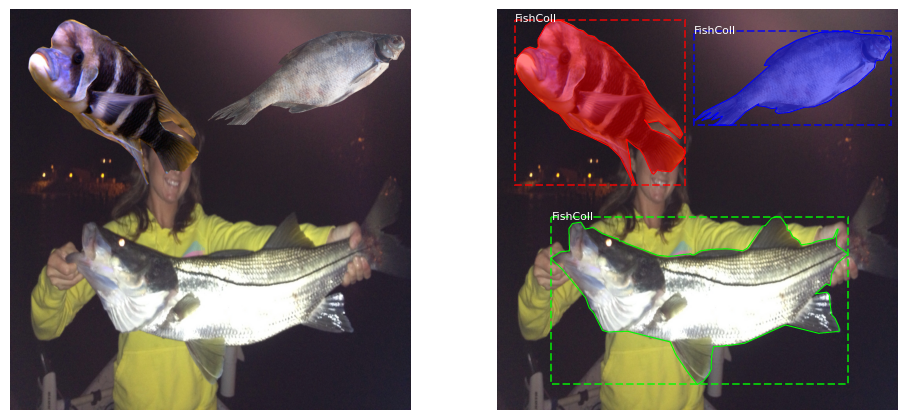

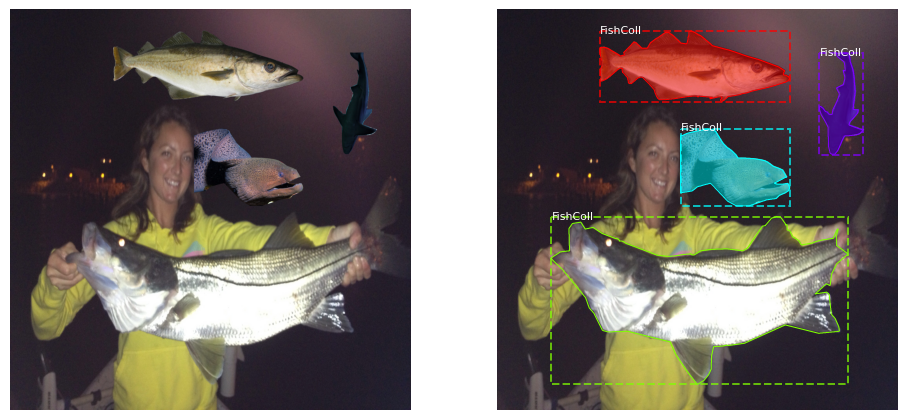

In [56]:
for indices in range(2):
    if len(dataset[indices]['annotations']) > 1:
        print("skip")
        continue
    img_data = apply_copy_paste_aug(dataset[0], data_valid_ann)

    f, ax = plt.subplots(1, 2, figsize=(16, 16))
    image = img_data['image']
    print("Shape: ", image.shape)
    
    masks = img_data['masks']
    bboxes = img_data['bboxes']
#     for i in masks:
#         plt.imshow(i)
#         plt.show()
#         print("Shape mask: ", i.shape)
    
    empty = np.array([])
    display_instances(image, empty, empty, empty, empty, show_mask=True, show_bbox=True, ax=ax[0])

    if len(bboxes) > 0:
        boxes = np.stack([b[:4] for b in bboxes], axis=0)
        box_classes = np.array([b[-2] for b in bboxes])
        mask_indices = np.array([b[-1] for b in bboxes])
        show_masks = np.stack(masks, axis=-1)[..., mask_indices]
        display_instances(image, boxes, show_masks, box_classes, "FishColl", show_bbox=True, ax=ax[1])


In [21]:
transforms.shape

AttributeError: 'TransformList' object has no attribute 'shape'